In [2]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import pandas as pd
import os
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

%run ../preproc/data_preproc.ipynb
%matplotlib inline

Using TensorFlow backend.


(2, 24, 1) (2, 1)


### Prepare data

In [3]:
input_dir = '../data'
input_files = [f for f in os.listdir(input_dir) if '.xlsx' in f]
input_files

['201711010800.xlsx',
 '201801010800.xlsx',
 '201802010800.xlsx',
 '201712010800.xlsx']

In [4]:
data = PreProc(input_dir, '蒸気')
data.input_dir
data.set_train_test_files('201801010800.xlsx', '201802010800.xlsx')
df=data.get_df(data.train_file)

y_train = data.strip(data.get_target(data.train_file, '需要蒸気'))
y_test = data.strip(data.get_target(data.test_file, '需要蒸気'))

y_train_norm = data.norm(y_train)

### Network design

In [5]:
len_x = 144

model=Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(len_x, 1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

plot_model(model, show_shapes=True, to_file='1d_conv_rnn.png')

from IPython.display import Image
#Image("1d_conv_rnn.png")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 140, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 46, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 32)            5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,617
Trainable params: 11,617
Non-trainable params: 0
_________________________________________________________________


### Training

In [6]:
batch_size_train = 32
steps = (len(y_train) - len_x) // batch_size_train

model.compile(optimizer=RMSprop(), loss='mae', metrics=['acc'])
history = model.fit_generator(generator=data.generator_1d_train(y_train_norm, len_x, batch_size_train),
                              steps_per_epoch=steps, shuffle=False, verbose=1,
                              epochs=20)

Epoch 1/20
18/18 [==============================] - 4s 211ms/step - loss: 0.7917 - acc: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 1s 76ms/step - loss: 0.3877 - acc: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 1s 83ms/step - loss: 0.2864 - acc: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 1s 80ms/step - loss: 0.1753 - acc: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 2s 84ms/step - loss: 0.1831 - acc: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 1s 79ms/step - loss: 0.2011 - acc: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 1s 82ms/step - loss: 0.2150 - acc: 0.0000e+00
Epoch 8/20
18/18 [==============================] - 1s 79ms/step - loss: 0.2191 - acc: 0.0000e+00
Epoch 9/20
18/18 [==============================] - 1s 78ms/step - loss: 0.2236 - acc: 0.0000e+00
Epoch 10/20
18/18 [==============================] - 1s 82ms/step - loss: 0.2535 - acc: 0.0000e+00
Epoch 11/20
18/18 

### Predicting

In [1]:
preds = []
for i in range(len(y_test) - len_x):
    pred = model.predict_generator(generator=data.generator_1d_test(y_test[steps - 1:], len_x, batch_size=1), steps=1)
    preds.append(data.denorm(pred[0]))
    
    '''incremental learning'''
    y_train = np.concatenate((y_train, y_test[:len_x + i + 1]), axis=0)
    y_train_norm = data.norm(y_train)
    
    steps = (len(y_train) - len_x) // batch_size_train
    history = model.fit_generator(generator=data.generator_1d_train(y_train_norm, len_x, batch_size_train), 
                                  steps_per_epoch=steps, shuffle=False, verbose=1, epochs=20)

NameError: name 'y_test' is not defined

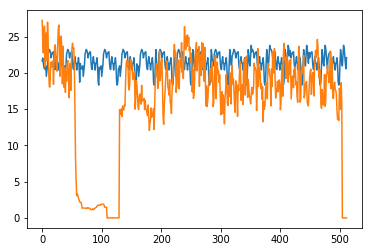

In [7]:
plt.plot(preds)
plt.plot(y_test[-512:])